# A results oriented view: double loop validation

Model selection is one of the basic skills needed by a machine learning practitioner. This notebook introduces a frequentist approach for model selection based on cross validation. Instead of considering the standard perspective of using a "double loop" for training and prediction of classifiers, we consider an alternative perspective of identifying the results that need to be produced.

We consider the question of *"Which classifier is better on my favourite datasets?"*
As an example, we use three well known datasets: [ionosphere](https://archive.ics.uci.edu/ml/datasets/Ionosphere), [bupa](https://archive.ics.uci.edu/ml/datasets/Liver+Disorders), [pima](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes); which are binary classification tasks. We will use two classifiers from [scikit-learn](http://scikit-learn.org/), the support vector machine (SVM) and the random forest (RF).

#### Setting up python environment ([do not use pylab](http://carreau.github.io/posts/10-No-PyLab-Thanks.ipynb.html))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Cross validation and hold out sets

Validation is a popular method for estimating generalisation error in machine learning. There are many resources available that describe it (for example [this FAQ](http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-11.html)), and why it is important to optimise for generalisation error and not training error. Please [look these up](http://lmgtfy.com/?q=generalisation+error+validation) if you are not familiar with this concept. The key idea is that we need to set some data aside that was not used for estimating the model so that we can properly measure the performance of our classifier. In particular we will use two strategies for keeping data aside:

* split sample or hold out validation
* cross validation

In split sample validation, a random subset of the data is held out for testing and the remaining data is used for training. To obtain multiple validation splits, the process is just repeated. For cross validation (for example 5 fold cross validation), the data is split into 5 pieces, and 4 of the pieces are used for training and 1 piece is used for validation. By considering each of the 5 pieces as a validation set in turn, we obtain 5 training/test splits that give us 5 estimates of validation error.

## Conventions used in this notebook

#### The problem of model selection

Machine learning algorithms often have parameters that need to be tuned. In the example below, we consider the support vector machine, where we have to tune the regularisation parameter $C$ and the Gaussian kernel bandwidth $\sigma$. How do we choose the best parameters? Well, by checking which parameters performs best on a validation set! If we only have one layer of validation, then we no longer have any data left to estimate the performance of this classifier with the best parameters.

#### Training, validation and test sets

It quickly becomes confusing when we think about how to do model selection. When reading literature about this issue, different words are used. For convenience, we will refer to the data that is used to train a classifier as **training set**, the data used for model selection as **validation set**, and the data used to report the final performance of the classifier as **test set**.

#### A recommended double loop strategy

We will use random splits to separate data into (training, validation) and (test) sets, and use cross validation for the "inner loop" of model selection that splits data into the (training) and (validation) sets. This makes the variable naming easier as we can refer to the iterates of the outer loop as *splits*, and the inner loop as *folds*.

## Comparing SVM and random forest

We would like to see whether the SVM is better or the random forest is better on the ionosphere data. We do so using the following experimental protocol:

* 10 random splits, with 30% of the data reserved for testing
* 5 fold cross validation to tune hyperparameters
* accuracy as a performance measure

In our imaginary paper, we would like to have a figure containing boxplots for a particular dataset.

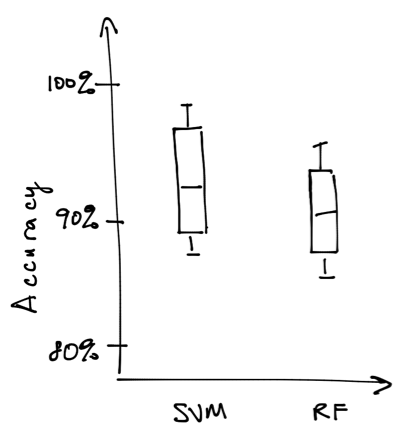

In [2]:
from IPython.display import Image
Image('dummy_perf.png')

The (imaginary) data used to generate this plot would be a matrix with two columns, one each for SVM and RF. Each column would contain the accuracy for each random split of the data. So for 10 splits, this means we have 10 rows. Note that this is only for one single dataset, and we would have 6 columns in total since we are considering three datasets. [Pandas](http://pandas.pydata.org/) provides a very useful concept of DataFrames, which would be familiar to people used to R.

In [3]:
datasets = ['bupa','ionosphere','pima']
methods = ['rf','svm']
num_splits = 10
split_idx = range(num_splits)
col_idx = pd.MultiIndex.from_product([datasets, methods], names=['dataset','method'])
# Create a dataframe with col_idx columns and split_idx rows
accuracy = pd.DataFrame(columns=col_idx, index=split_idx)
accuracy.index.name = 'split'
print(accuracy)

dataset bupa      ionosphere      pima     
method    rf  svm         rf  svm   rf  svm
split                                      
0        NaN  NaN        NaN  NaN  NaN  NaN
1        NaN  NaN        NaN  NaN  NaN  NaN
2        NaN  NaN        NaN  NaN  NaN  NaN
3        NaN  NaN        NaN  NaN  NaN  NaN
4        NaN  NaN        NaN  NaN  NaN  NaN
5        NaN  NaN        NaN  NaN  NaN  NaN
6        NaN  NaN        NaN  NaN  NaN  NaN
7        NaN  NaN        NaN  NaN  NaN  NaN
8        NaN  NaN        NaN  NaN  NaN  NaN
9        NaN  NaN        NaN  NaN  NaN  NaN


The SVM has a regularisation parameter that needs to be set, and potentially its kernel also has parameters. As mentioned before, this is done using an inner loop. What is the information that is needed? For each split and dataset, we need to store the best (hyper)parameters of the SVM. Note that different parameters may be best for different splits of the data.

In [4]:
params = ['C','sigma']
col_idx = pd.MultiIndex.from_product([datasets, params], names=['dataset','param'])
best_param = pd.DataFrame(columns=col_idx, index=split_idx)
best_param.index.name = 'split'
print(best_param)

dataset bupa       ionosphere       pima      
param      C sigma          C sigma    C sigma
split                                         
0        NaN   NaN        NaN   NaN  NaN   NaN
1        NaN   NaN        NaN   NaN  NaN   NaN
2        NaN   NaN        NaN   NaN  NaN   NaN
3        NaN   NaN        NaN   NaN  NaN   NaN
4        NaN   NaN        NaN   NaN  NaN   NaN
5        NaN   NaN        NaN   NaN  NaN   NaN
6        NaN   NaN        NaN   NaN  NaN   NaN
7        NaN   NaN        NaN   NaN  NaN   NaN
8        NaN   NaN        NaN   NaN  NaN   NaN
9        NaN   NaN        NaN   NaN  NaN   NaN


What needs to be done to find these best parameters? We need to fill in a table that contains the accuracy of five fold cross validation for each combination of parameters. Note that we only need to do this for SVM

In [5]:
Cs = [0.1, 1., 10.0]
sigmas = [1e-2, 1e-1]
num_cv = 5
folds = range(5)
col_idx = pd.MultiIndex.from_product([datasets, Cs, sigmas], names=['dataset','C','sigma'])
row_idx = pd.MultiIndex.from_product([split_idx, folds], names=['split','fold'])
cv_accuracy = pd.DataFrame(columns=col_idx, index=row_idx)
print(cv_accuracy.head(13))

dataset    bupa                          ionosphere                           \
C          0.1       1.0       10.0            0.1       1.0       10.0        
sigma      0.01 0.10 0.01 0.10 0.01 0.10       0.01 0.10 0.01 0.10 0.01 0.10   
split fold                                                                     
0     0     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      1     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      2     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      3     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      4     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
1     0     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      1     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      2     NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN   
      3     NaN  NaN  NaN  NaN  NaN  NaN

That is all there is for the conceptual part of the double loop procedure for doing model selection with the inner loop and then using the best parameters for each split to estimate the performance on the test set. Therefore all we need to do now is implement the code to fill in the values in the dataframes appropriately.

## Experimental protocol (implementation details)

### Implementation of data splitting for validation

Recall that for split sample validation, a random subset of the data is held out for testing and the remaining data is used for training. To obtain multiple validation splits, the process is just repeated. For cross validation (for example 5 fold cross validation), the data is split into 5 pieces, and 4 of the pieces are used for training and 1 piece is used for validation. By considering each of the 5 pieces as a validation set in turn, we obtain 5 training/test splits that give us 5 estimates of validation error.

In [6]:
def random_split(orig_idx, split_idx, frac_train=0.7):
    """Returns training and prediction indices which are subsets of orig_idx.
    split_idx is for reproducibility of the random permutation.
    
    np.random.RandomState is not portable between machines.
    """
    prng = np.random.RandomState(split_idx)
    num_data = len(orig_idx)
    num_train = int(np.round(frac_train*num_data))
    perm_idx = prng.permutation(num_data)
    train_idx = orig_idx[perm_idx[:num_train]]
    pred_idx = orig_idx[perm_idx[num_train:]]
    return train_idx, pred_idx

def cross_val(orig_idx, fold, num_cv=5):
    """Returns training and prediction indices of cross validation,
    for fold 'fold' in num_cv.
    """
    num_data = len(orig_idx)
    train = []
    pred = []
    for ix in range(num_data):
        if ix % num_cv == fold:
            pred.append(ix)
        else:
            train.append(ix)
    train_idx = orig_idx[np.array(train)]
    pred_idx = orig_idx[np.array(pred)]
    return train_idx, pred_idx

orig_idx = np.arange(20, dtype=int)
print(random_split(orig_idx, 1))
print(random_split(orig_idx, 4))
print(random_split(orig_idx, 1))
print(cross_val(orig_idx, 0))
print(cross_val(orig_idx, 3))

(array([ 3, 16,  6, 10,  2, 14,  4, 17,  7,  1, 13,  0, 19, 18]), array([ 9, 15,  8, 12, 11,  5]))
(array([19,  3, 18,  6, 13,  4,  0, 17, 12, 11, 15, 10,  9,  2]), array([16,  7,  8,  1,  5, 14]))
(array([ 3, 16,  6, 10,  2, 14,  4, 17,  7,  1, 13,  0, 19, 18]), array([ 9, 15,  8, 12, 11,  5]))
(array([ 1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19]), array([ 0,  5, 10, 15]))
(array([ 0,  1,  2,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 19]), array([ 3,  8, 13, 18]))


#### A recommended double loop strategy

We will use random splits to separate data into (training, validation) and (test) sets, and use cross validation for the "inner loop" of model selection that splits data into the (training) and (validation) sets.

In [7]:
# Split data into (training,validation) and (test) sets
split_train_val, split_test = random_split(orig_idx, 1)
# First fold of the cross validation
train_idx, pred_idx = cross_val(split_train_val,0)
print(train_idx, pred_idx)
# Second fold of the cross validation
train_idx, pred_idx = cross_val(split_train_val,1)
print(train_idx, pred_idx)


[16  6 10  2  4 17  7  1  0 19 18] [ 3 14 13]
[ 3  6 10  2 14 17  7  1 13 19 18] [16  4  0]


### Interface to classifier

We have hidden away the complexity of the classifier in a separate file. In particular, there is only one common interface, which is a train_and_predict function. All this function needs to know is the dataset under consideration, the index of the training and prediction instances, the classifier to be used, and hyperparameter values (if any).

    def train_and_predict(data_name, train_idx, pred_idx, method, C=None, sigma=None, verbose=False):
        """Work out which classifier to call on data_name.
        Then train the classifier, and predict on the validation set.

        return the accuracy of the classifier on the prediction set.
        """


## The actual code that does the computations

We summarise the setup that we have:

* manage the indices of examples to be used for training and prediction
* an interface to train a classifer and predict on the prediction set

For random forest, there is no need for any hyperparameter selection, so we can directly fill in the final accuracy results.

In [8]:
from classifier import train_and_predict

idx = pd.IndexSlice
num_ex = {'bupa': 345, 'ionosphere': 351, 'pima': 768}
for data_name in datasets:
    orig_idx = np.arange(num_ex[data_name], dtype=int)
    for split in split_idx:
        train_idx, pred_idx = random_split(orig_idx, split)
        acc = train_and_predict(data_name, train_idx, pred_idx, 'rf')
        accuracy.loc[split,idx[data_name,'rf']] = acc
print(accuracy)

dataset      bupa      ionosphere           pima     
method         rf  svm         rf  svm        rf  svm
split                                                
0        0.673077  NaN   0.961905  NaN  0.747826  NaN
1        0.711538  NaN   0.914286  NaN  0.726087  NaN
2        0.769231  NaN   0.933333  NaN  0.769565  NaN
3        0.769231  NaN   0.942857  NaN  0.786957  NaN
4            0.75  NaN    0.92381  NaN  0.730435  NaN
5        0.740385  NaN    0.92381  NaN  0.743478  NaN
6        0.711538  NaN   0.914286  NaN  0.782609  NaN
7        0.721154  NaN   0.933333  NaN  0.786957  NaN
8        0.730769  NaN   0.933333  NaN  0.721739  NaN
9        0.634615  NaN   0.914286  NaN  0.747826  NaN


The SVM requires an inner loop for finding the best parameters

In [9]:
for data_name in datasets:
    orig_idx = np.arange(num_ex[data_name], dtype=int)
    for split in split_idx:
        tv_idx, test_idx = random_split(orig_idx, split)
        for fold in folds:
            train_idx, pred_idx = cross_val(tv_idx, fold)
            for C in Cs:
                for sigma in sigmas:
                    acc = train_and_predict(data_name, train_idx, pred_idx, 'svm', C=C, sigma=sigma)
                    cv_accuracy.loc[idx[split,fold],idx[data_name,C,sigma]] = acc
print(cv_accuracy.head())

dataset         bupa                                                    \
C               0.1                 1.0                 10.0             
sigma           0.01      0.10      0.01      0.10      0.01      0.10   
split fold                                                               
0     0     0.387755  0.387755  0.408163  0.653061  0.612245  0.714286   
      1     0.458333  0.458333  0.479167  0.666667     0.625  0.645833   
      2     0.416667  0.416667  0.458333  0.645833     0.625    0.6875   
      3     0.354167  0.354167  0.354167  0.604167  0.520833     0.625   
      4     0.479167  0.479167  0.520833    0.6875     0.625  0.729167   

dataset    ionosphere                                                    \
C                0.1                 1.0                 10.0             
sigma            0.01      0.10      0.01      0.10      0.01      0.10   
split fold                                                                
0     0           0.7      0.66  

Now that we have all the values for the inner loop, we can collect the best parameters for each split.

In [10]:
def find_best_param(cv_accuracy, dataset, split):
    """Given the (inner) cross validation accuracies for all parameters,
    find the parameters that give the best average performance.
    """
    idx = pd.IndexSlice
    cv = cv_accuracy.loc[idx[split],idx[dataset]]
    avg_cv = cv.mean(axis=0)
    best_param = avg_cv.idxmax()
    return best_param


In [11]:
for data_name in datasets:
    for split in split_idx:
        C, sigma = find_best_param(cv_accuracy, data_name, split)
        best_param.loc[split, idx[data_name,'C']] = C
        best_param.loc[split, idx[data_name,'sigma']] = sigma
print(best_param)

dataset bupa       ionosphere       pima      
param      C sigma          C sigma    C sigma
split                                         
0         10   0.1          1   0.1    1  0.01
1         10   0.1          1   0.1   10   0.1
2         10   0.1          1   0.1    1  0.01
3         10   0.1          1   0.1    1  0.01
4         10   0.1         10   0.1   10  0.01
5         10   0.1         10   0.1   10  0.01
6         10   0.1          1   0.1   10   0.1
7         10   0.1          1   0.1   10   0.1
8         10   0.1          1   0.1    1  0.01
9         10   0.1          1   0.1    1  0.01


Note that different splits could have different optimal parameters. As an important aside, it is good to reflect on what conclusions you can draw by looking at the boxplots of accuracy. There are really multiple classifiers here, and not just one single SVM. Not only are the training data different, but the parameters are different too. Now we are ready to train the final SVMs.

In [12]:
for data_name in datasets:
    orig_idx = np.arange(num_ex[data_name], dtype=int)
    for split in split_idx:
        train_idx, pred_idx = random_split(orig_idx, split)
        C = best_param.loc[split, idx[data_name,'C']]
        sigma = best_param.loc[split, idx[data_name,'sigma']]
        acc = train_and_predict(data_name, train_idx, pred_idx, 'svm', C=C, sigma=sigma)
        accuracy.loc[split,idx[data_name,'svm']] = acc
print(accuracy)

dataset      bupa           ionosphere                pima          
method         rf       svm         rf       svm        rf       svm
split                                                               
0        0.673077  0.605769   0.961905  0.971429  0.747826  0.721739
1        0.711538     0.625   0.914286  0.942857  0.726087  0.704348
2        0.769231  0.634615   0.933333  0.933333  0.769565  0.730435
3        0.769231  0.634615   0.942857  0.961905  0.786957  0.726087
4            0.75  0.711538    0.92381  0.952381  0.730435  0.726087
5        0.740385  0.653846    0.92381  0.904762  0.743478  0.730435
6        0.711538  0.615385   0.914286  0.933333  0.782609  0.704348
7        0.721154  0.653846   0.933333  0.961905  0.786957   0.73913
8        0.730769  0.596154   0.933333  0.942857  0.721739  0.708696
9        0.634615  0.615385   0.914286  0.952381  0.747826   0.76087


**That's it!**. The results of the experiment are in the above table. We can visualise this table as boxplots.

Text(0.5, 0.98, 'Performance comparison of SVM and random forest')

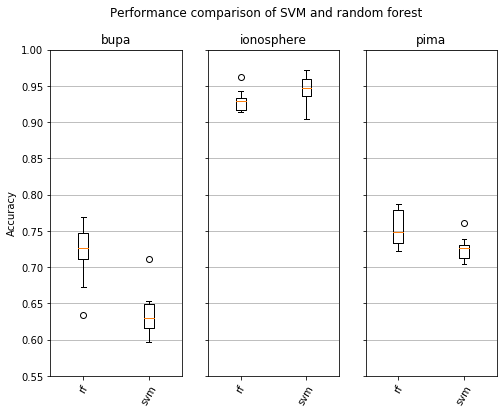

In [13]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8,6))
axes[0].set_ylabel('Accuracy')
for ix,data_name in enumerate(datasets):
    ax = axes[ix]
    acc = accuracy.loc[:,data_name].values
    ax.boxplot([list(acc[:,0]), list(acc[:,1])])
    ax.set_xticklabels(methods, rotation=60)
    ax.set_title(data_name)
    ax.set_ylim(bottom=0.55, top=1.)
    ax.yaxis.grid(True)
fig.suptitle('Performance comparison of SVM and random forest')